<a href="https://colab.research.google.com/github/Stephanie-Daniella/Stock-Returns-Neural-Nerwork/blob/main/Index_Neural_Network_Returns_Individual_Daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (7, 7)
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import random
import math

# Data Cleaning

In [2]:
Start_Date_Str='2012-01-01'
Final_Date_Str='2025-03-15'

In [3]:
data=yf.download('AAPL',start=Start_Date_Str,end=Final_Date_Str,interval='1d', auto_adjust=False)
AAPL_Rend=data['Adj Close'].pct_change()

[*********************100%***********************]  1 of 1 completed


In [4]:
data


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2012-01-03,12.375391,14.686786,14.732143,14.607143,14.621429,302220800
2012-01-04,12.441895,14.765714,14.810000,14.617143,14.642857,260022000
2012-01-05,12.580029,14.929643,14.948214,14.738214,14.819643,271269600
2012-01-06,12.711535,15.085714,15.098214,14.972143,14.991786,318292800
2012-01-09,12.691371,15.061786,15.276786,15.048214,15.196429,394024400
...,...,...,...,...,...,...
2025-03-10,227.479996,227.479996,236.160004,224.220001,235.539993,72071200
2025-03-11,220.839996,220.839996,225.839996,217.449997,223.809998,76137400


In [5]:
AAPL_Rend= pd.DataFrame(AAPL_Rend)
AAPL_Rend

Ticker,AAPL
Date,
2012-01-03,NaN
2012-01-04,0.005374
2012-01-05,0.011102
2012-01-06,0.010454
2012-01-09,-0.001586
...,...
2025-03-10,-0.048480
2025-03-11,-0.029189
2025-03-12,-0.017479


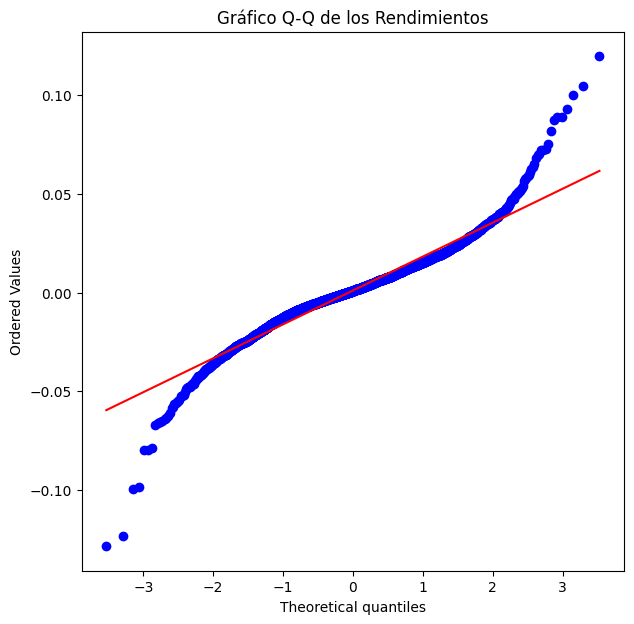

In [6]:
import scipy.stats as stats

# Gráfico Q-Q
stats.probplot(AAPL_Rend['AAPL'][1:].values, dist="norm", plot=plt)
plt.title("Gráfico Q-Q de los Rendimientos")
plt.show()

In [7]:
def classify_trend_from_returns(returns, n, threshold=None):

    rolling_sum = pd.Series(returns).rolling(window=n).sum().dropna().values

    # Si no se define un threshold, usar la desviación estándar como referencia
    if threshold is None:
        threshold = .3 * np.std(returns)  # 0.5σ como punto de partida

    # Definir la tendencia con base en el umbral
    trends = np.zeros(len(rolling_sum))
    trends[rolling_sum > threshold] = 2  # Alcista
    trends[rolling_sum < -threshold] = 0  # Bajista
    trends[(rolling_sum >= -threshold) & (rolling_sum <= threshold)] = 1  # Neutral

    return trends, threshold,rolling_sum

In [8]:
classify_trend_from_returns(AAPL_Rend['AAPL'][1:].values, 15, threshold=None)

(array([2., 2., 2., ..., 0., 0., 0.]),
 np.float64(0.0053110372396687035),
 array([ 0.08522298,  0.07530403,  0.0701618 , ..., -0.11816437,
        -0.15572852, -0.13641892]))

In [9]:
Trend,Indicator,Sum=classify_trend_from_returns(AAPL_Rend['AAPL'][1:].values, 15, threshold=None)

In [10]:
df=pd.DataFrame(data['Adj Close'][15:])
df['Trend']=Trend
df

Ticker,AAPL,Trend
Date,,
2012-01-25,13.441608,2.0
2012-01-26,13.380516,2.0
2012-01-27,13.460264,2.0
2012-01-30,13.632705,2.0
2012-01-31,13.737123,2.0
...,...,...
2025-03-10,227.479996,0.0
2025-03-11,220.839996,0.0
2025-03-12,216.979996,0.0


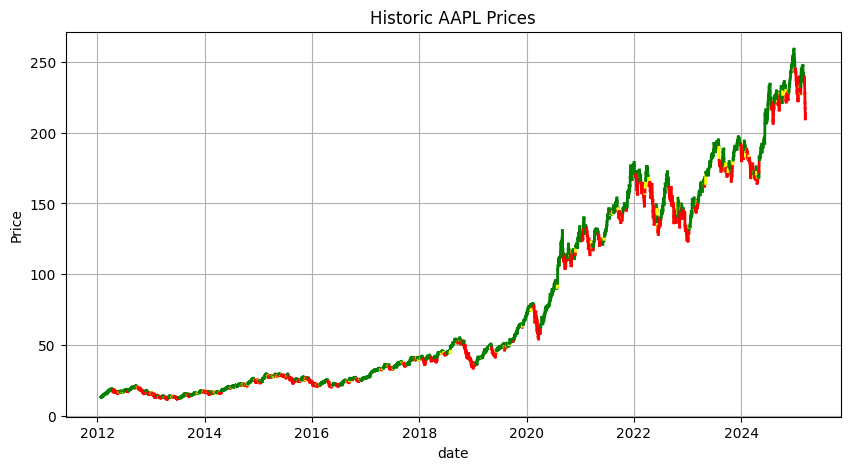

In [11]:
colores = {0: "red", 1: "yellow", 2: "green"}

plt.figure(figsize=(10, 5))

for i in range(len(df) - 1):
    plt.plot(df.index[i:i+2], df["AAPL"].iloc[i:i+2], color=colores[df["Trend"].iloc[i]], linewidth=2)

plt.xlabel("date")
plt.ylabel("Price")
plt.title("Historic AAPL Prices")
plt.grid()
plt.show()

In [12]:
Indicator

np.float64(0.0053110372396687035)

In [13]:
window_size = 16
transformed_AAPL_Rend = []

# Building the observations, 15 predictors returns and the change predicted
for i in range(1,len(AAPL_Rend) - window_size+2):
    row = AAPL_Rend['AAPL'][i:i + window_size-1].values
    transformed_AAPL_Rend.append(row)

# Create a DataFrame
columns = [f'Change_{i}' for i in range(1, window_size)]
transformed_AAPL_Rend = pd.DataFrame(transformed_AAPL_Rend, columns=columns)

transformed_AAPL_Rend['Sum']=Sum
transformed_AAPL_Rend['Trend']=Trend

# Results
transformed_AAPL_Rend[0:11]

,Change_1,Change_2,Change_3,Change_4,Change_5,Change_6,Change_7,Change_8,Change_9,Change_10,Change_11,Change_12,Change_13,Change_14,Change_15,Sum,Trend
0,0.005374,0.011102,0.010454,-0.001586,0.003581,-0.001631,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,0.085223,2.0
1,0.011102,0.010454,-0.001586,0.003581,-0.001631,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.075304,2.0
2,0.010454,-0.001586,0.003581,-0.001631,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.005960,0.070162,2.0
3,-0.001586,0.003581,-0.001631,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.005960,0.012811,0.072519,2.0
4,0.003581,-0.001631,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.005960,0.012811,0.007659,0.081765,2.0
5,-0.001631,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.005960,0.012811,0.007659,-0.000635,0.077549,2.0
6,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.005960,0.012811,0.007659,-0.000635,-0.002345,0.076834,2.0
7,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.005960,0.012811,0.007659,-0.000635,-0.002345,0.010019,0.089598,2.0
8,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.005960,0.012811,0.007659,-0.000635,-0.002345,0.010019,0.009333,0.102681,2.0
9,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.005960,0.012811,0.007659,-0.000635,-0.002345,0.010019,0.009333,0.010475,0.101507,2.0


In [14]:
del transformed_AAPL_Rend['Trend']
del transformed_AAPL_Rend['Sum']
transformed_AAPL_Rend

,Change_1,Change_2,Change_3,Change_4,Change_5,Change_6,Change_7,Change_8,Change_9,Change_10,Change_11,Change_12,Change_13,Change_14,Change_15
0,0.005374,0.011102,0.010454,-0.001586,0.003581,-0.001631,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439
1,0.011102,0.010454,-0.001586,0.003581,-0.001631,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545
2,0.010454,-0.001586,0.003581,-0.001631,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.005960
3,-0.001586,0.003581,-0.001631,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.005960,0.012811
4,0.003581,-0.001631,-0.002745,-0.003749,0.011648,0.010384,-0.003169,-0.017417,0.016917,-0.016378,0.062439,-0.004545,0.005960,0.012811,0.007659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3299,-0.000531,0.001636,0.003920,-0.001139,0.006312,-0.000243,-0.027040,-0.012731,0.019132,-0.015754,-0.008822,-0.000805,-0.001739,0.015893,-0.048480
3300,0.001636,0.003920,-0.001139,0.006312,-0.000243,-0.027040,-0.012731,0.019132,-0.015754,-0.008822,-0.000805,-0.001739,0.015893,-0.048480,-0.029189
3301,0.003920,-0.001139,0.006312,-0.000243,-0.027040,-0.012731,0.019132,-0.015754,-0.008822,-0.000805,-0.001739,0.015893,-0.048480,-0.029189,-0.017479
3302,-0.001139,0.006312,-0.000243,-0.027040,-0.012731,0.019132,-0.015754,-0.008822,-0.000805,-0.001739,0.015893,-0.048480,-0.029189,-0.017479,-0.033644


# Neural Network

In [15]:
from keras import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers import Dropout, LeakyReLU
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, LayerNormalization
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

In [16]:
Top=int(Trend.size*.8)+1

In [17]:
Y_Train=Trend[0:Top]
Y_Test=Trend[Top:]
X_Train=transformed_AAPL_Rend[0:Top]
X_Test=transformed_AAPL_Rend[Top:]

In [18]:
modeloUni_3 = Sequential()
modeloUni_3.add(Dense(12, input_dim=15))
modeloUni_3.add(BatchNormalization())
modeloUni_3.add(LeakyReLU(alpha=0.1))

modeloUni_3.add(Dense(20))
modeloUni_3.add(LeakyReLU(alpha=0.1))
modeloUni_3.add(Dropout(0.25))

modeloUni_3.add(Dense(8))
modeloUni_3.add(BatchNormalization())
modeloUni_3.add(LeakyReLU(alpha=0.1))

modeloUni_3.add(Dense(3, activation='softmax'))
modeloUni_3.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12)                  │              48 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 20)                  │             260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8)                   │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │              27 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 727 (2.84 KB)

 Trainable params: 687 (2.68 KB)

 Non-trainable params: 40 (160.00 B)

In [19]:
random.seed(996)
Batch_size = 16

modeloUni_3.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
modeloUni_3.fit(X_Train, Y_Train, epochs=50, batch_size=Batch_size, verbose=1);

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3820 - loss: 1.2140
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7304 - loss: 0.7525
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8013 - loss: 0.5602
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8545 - loss: 0.4239
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8593 - loss: 0.3954
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8638 - loss: 0.3792
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8491 - loss: 0.3857
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8706 - loss: 0.3712
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8659 - loss: 0.3714
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8380 - loss: 0.3989
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8724 - loss: 0.3458
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

In [20]:
modeloUni_3.evaluate(X_Test, Y_Test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9089 - loss: 0.2769  


[0.3054026663303375, 0.8984848260879517]

In [21]:
predicciones = modeloUni_3.predict(X_Test)
pred_clases = np.argmax(predicciones, axis=1)
print(pred_clases[:10])

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[2 2 2 2 2 2 2 2 2 2]


# Graph Train Data

In [22]:
Y_Predict_Test_Prob=modeloUni_3.predict(X_Test)
Y_Predict_Test_Class = np.argmax(Y_Predict_Test_Prob, axis=1)
Y_Predict_Test_Class=pd.DataFrame(Y_Predict_Test_Class)
Y_Predict_Test_Class.columns=['Trend']
Y_Predict_Test_Class=Y_Predict_Test_Class.set_index([pd.Index(data.index[-660:]
)])

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [23]:
Y_Predict_Test_Class

,Trend
Date,
2022-07-28,2
2022-07-29,2
2022-08-01,2
2022-08-02,2
2022-08-03,2
...,...
2025-03-10,0
2025-03-11,0
2025-03-12,0


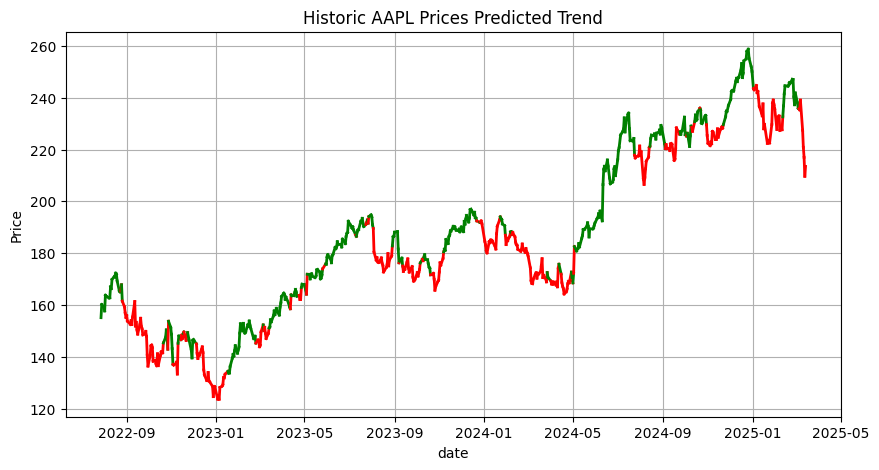

In [24]:
colores = {0: "red", 1: "blue", 2: "green"}

plt.figure(figsize=(10, 5))

for i in range(len(Y_Test) - 1):
    plt.plot(Y_Predict_Test_Class.index[i:i+2], df["AAPL"][-len(Y_Test):].iloc[i:i+2], color=colores[Y_Predict_Test_Class["Trend"].iloc[i]], linewidth=2)

plt.xlabel("date")
plt.ylabel("Price")
plt.title("Historic AAPL Prices Predicted Trend")
plt.grid()
plt.show()

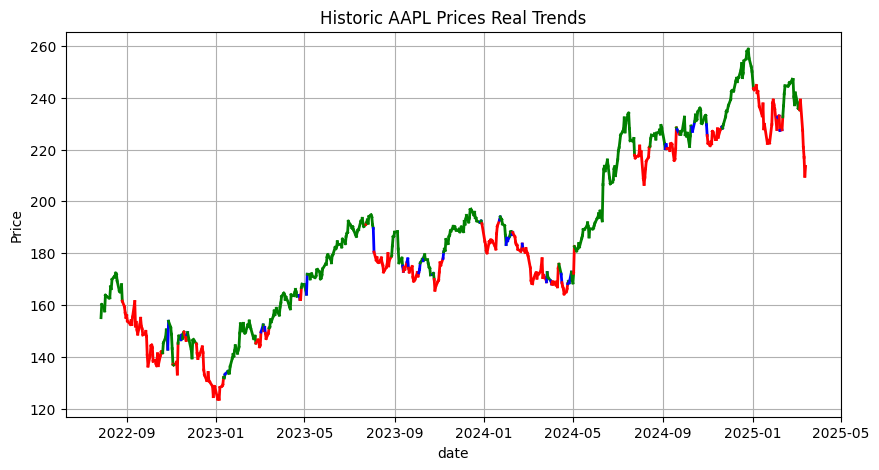

In [25]:
colores = {0: "red", 1: "blue", 2: "green"}

plt.figure(figsize=(10, 5))

for i in range(len(Y_Test) - 1):
    plt.plot(Y_Predict_Test_Class.index[i:i+2], df["AAPL"][-len(Y_Test):].iloc[i:i+2], color=colores[Y_Test[i]], linewidth=2)

plt.xlabel("date")
plt.ylabel("Price")
plt.title("Historic AAPL Prices Real Trends")
plt.grid()
plt.show()